In [27]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io
from datetime import datetime
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
file_loc = "../Matlab/EERdatabase.xlsx"

In [10]:
# basically after they read in the file they do some calculation and turn them
# into a file call data_vars.mat
# 

# replicates the reading phase

# read in the files
cpi = pd.read_excel(file_loc, sheet_name="cpi",engine="openpyxl") 

USD = pd.read_excel(file_loc, sheet_name="ner_eop",engine="openpyxl") 

gdp = pd.read_excel(file_loc, sheet_name="gdppc_ppp",engine="openpyxl") 

nfa = pd.read_excel(file_loc, sheet_name="nfa2gdp",engine="openpyxl") 

tot = pd.read_excel(file_loc, sheet_name="tot_all",engine="openpyxl") 

weights = pd.read_excel(file_loc, sheet_name="weights_static",engine="openpyxl") 

# pre cleaning / define some variables that would be useful
time_line = cpi.iloc[:,0]
time_line = pd.DataFrame(time_line)
time_line.columns = ["Time"]
time_line["Time"] = pd.PeriodIndex(time_line["Time"], freq='Q').to_timestamp()
time_line["Year"] = time_line["Time"].dt.year
time_line["Q"] = time_line["Time"].dt.quarter

countries = list(cpi.columns)[1:]

# the first columns is always time, we DO NOT need them in the calculation
cpi = cpi.iloc[:,1:].to_numpy()
gdp = gdp.iloc[:,1:].to_numpy()
USD = USD.iloc[:,1:].to_numpy()
nfa = nfa.iloc[:,1:].to_numpy()
tot = tot.iloc[:,1:].to_numpy()

# weights

# following their reindexing into alphabetic order
weights.columns = ["country", 
"time", 
"USA", 
"GBR", 
"DNK",
"NOR",
"SWE", 
"CHE",
"CAN",
"JPN",
"EA",
"AUS",
"NZL"]
weights.set_index("country", inplace=True)
weights = weights.reindex(index=sorted(weights.index), columns=sorted(weights.columns))
# they fill the na with 0 for weights
weights = weights.fillna(0)
weights.drop(columns="time", inplace=True)
weights = weights.to_numpy()


# calculations below 

# log of relative CPI
rpi = np.log(cpi)- np.log(cpi)@weights
#  log of USD rate (increase stands for appreciation of dom. currency)
ner = np.log(USD)@weights - np.log(USD)
# log of USD real rate (increase stands for appreciation)
rer = ner + rpi

# log of relative gdp per capita
rgdp = np.log(gdp) - np.log(gdp)@weights

# log of relative terms of trade

rtot = np.log(tot) - np.log(tot)@weights

# relative nfa (choose which one)
rnfa = nfa-nfa@weights


### in the original code they get rid of denmark 
rpi = np.delete(rpi ,3,1)  
ner = np.delete(ner,3,1)  
rer = np.delete(rer,3,1) 
rgdp = np.delete(rgdp,3,1) 
rtot = np.delete(rtot,3,1) 
rnfa = np.delete(rnfa, 3,1)
countries.remove("DNK")


In [11]:
# A2_EqRERstimates

# periods in the paper (-1 in the end because Python)
period_start = 4*(1994-1975) + (4-1) +1 - 1
period_end = time_line.shape[0]

# this is the recursive part
# the regression table is the last recursive, meaning the from 80 to 176
#for i in range(period_start, period_end):
#    rerR = rer[0:i,:]
#    gdpR = rgdp[0:i,:]
#    nfaR = rnfa[0:i,:]
#    totR = rtot[0:i,:]

In [33]:

# because its Python the structure below makes way more sense
timeR = time_line.iloc[:period_end,:]

rerR = pd.DataFrame(rer[0:period_end,:], columns=countries)
gdpR = pd.DataFrame(rgdp[0:period_end,:], columns=countries)
nfaR = pd.DataFrame(rnfa[0:period_end,:], columns=countries)
totR = pd.DataFrame(rtot[0:period_end,:], columns=countries)
 
rerR = pd.concat([timeR["Time"], rerR], axis=1)
gdpR =  pd.concat([timeR["Time"], gdpR], axis=1)
nfaR =  pd.concat([timeR["Time"], nfaR], axis=1)
totR =  pd.concat([timeR["Time"], totR], axis=1)

rerR = rerR.melt(id_vars="Time", var_name="Country", value_name="rerR")
gdpR = gdpR.melt(id_vars="Time", var_name="Country", value_name="gdpR")
nfaR = nfaR.melt(id_vars="Time", var_name="Country", value_name="nfaR")
totR = totR.melt(id_vars="Time", var_name="Country", value_name="totR")


out = pd.merge(rerR, gdpR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])
out = pd.merge(out, nfaR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])
out = pd.merge(out, totR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])

out["Country"] = out["Country"].astype("category")
out.set_index(['Country', 'Time'], inplace=True)
exog_vars = out[["gdpR", "nfaR", "totR"]]
mod1 = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True)
# the fixed effects of both the country and time_effects is closest to the results
fe_te_res = mod1.fit()
fe_te_res

Dep. Variable:,rerR,R-squared:,0.2449
Estimator:,PanelOLS,R-squared (Between):,-0.0293
No. Observations:,1760,R-squared (Within):,0.2436
Date:,"Wed, Feb 09 2022",R-squared (Overall):,-0.0280
Time:,09:18:12,Log-likelihood,1497.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,169.99
Entities:,10,P-value,0.0000
Avg Obs:,176.00,Distribution:,"F(3,1572)"
Min Obs:,176.00,,
Max Obs:,176.00,F-statistic (robust):,169.99


In [13]:
values = pd.DataFrame(fe_te_res.params)
pvalues = pd.DataFrame(fe_te_res.pvalues)
final = values.join(pvalues)

exog_vars = out[["gdpR"]]
mod = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod.pvalues)], axis=1)

exog_vars = out[["nfaR"]]
mod = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod.pvalues)], axis=1)


exog_vars = out[["totR"]]
mod = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod.pvalues)], axis=1)

final.columns = ["All Three Parameters", "All Three Parameters"] +  2*["GDP only"] + 2*["NFA only"] + 2*["ToT only"]

In [14]:
final

,All Three Parameters,All Three Parameters,GDP only,GDP only,NFA only,NFA only,ToT only,ToT only
gdpR,0.191785,0.000076,0.264802,0.000002,NaN,NaN,NaN,NaN
nfaR,-0.019221,0.010966,NaN,NaN,-0.020547,0.01764,NaN,NaN
totR,0.424363,0.000000,NaN,NaN,NaN,NaN,0.42908,0.0


In [15]:
# testing another package with FullyModifiedOLS => result is less than ideal than PanelOLS with Fixed effects

from arch.unitroot.cointegration import FullyModifiedOLS

test = FullyModifiedOLS(out["rerR"].to_numpy(), out[["gdpR", "nfaR", "totR"]].to_numpy(), trend='c', x_trend="c").fit()
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Fully Modified OLS                              
==============================================================================
Trend:                       Constant   No. Observations:                 1760
Kernel:                      Bartlett   R²:                             0.2286
Bandwidth:                         36   Adjusted. R²:                   0.2273
                                        Residual Variance:              2.3264
                                        Long-run Variance:              73.437
                                                                              
                             Cointegrating Vector                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
x1             1.9568     1.0836     1.8059     0.0709     -0.1669      4.0806
x2            -1.0664     0.3971    -2.6853     0.0072     -1.8447     -0.2880
x3            -2.3548     0.9987    -2.3579     0.0184     -4.3123     -0.3974
const         -0.3804     0.2154    -1.7662     0.0774     -0.8026      0.0417
==============================================================================
"""

In [39]:
## in-sample forecast (BEER)
para = fe_te_res.params.to_numpy()
graph_df = out[["gdpR", "nfaR", "totR"]]
graph_df["gdpR"] = para[0]*graph_df["gdpR"]
graph_df["nfaR"] = para[1]*graph_df["nfaR"]
graph_df["totR"] = para[2]*graph_df["totR"]
graph_df["prediction"] = graph_df["totR"] + graph_df["nfaR"] + graph_df["gdpR"]
graph_df["rerR"] = out[["rerR"]]

#graph_df = graph_df.join(out[["rerR"]])
graph_df.reset_index(inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [52]:
graph_df.Country.unique()

['AUS', 'CAN', 'CHE', 'EA', 'GBR', 'JPN', 'NOR', 'NZL', 'SWE ', 'USA']
Categories (10, object): ['AUS', 'CAN', 'CHE', 'EA', ..., 'NOR', 'NZL', 'SWE ', 'USA']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='Time', ylabel='prediction'>

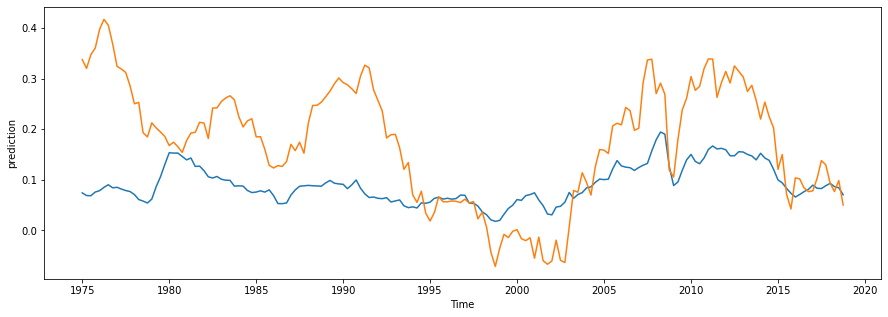

In [53]:
test = graph_df[graph_df.Country=="CAN"]
test["mean"] = test.rerR.mean()
rho = 0.5**(1/12)
test["prediction"] = rho*test["prediction"] + test["mean"]
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data= test, x="Time", y="prediction", ax=ax)
sns.lineplot(data= test, x="Time", y="rerR", ax=ax)

In [25]:
test

,Country,Time,predictions,rerR
0,AUS,1975-01-01,-0.183392,1.203286
1,AUS,1975-04-01,-0.186147,1.205045
2,AUS,1975-07-01,-0.188492,1.189019
3,AUS,1975-10-01,-0.185932,1.221306
4,AUS,1976-01-01,-0.191935,1.233522
...,...,...,...,...
171,AUS,2017-10-01,-0.010765,1.132611
172,AUS,2018-01-01,0.004624,1.091224
173,AUS,2018-04-01,0.007103,1.089979
174,AUS,2018-07-01,0.014063,1.072927
